In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import warnings

warnings.filterwarnings("ignore")

# Start the spark context
sc = SparkContext.getOrCreate(conf=swan_spark_conf) 
print("Created Spark Context")

# create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()
print("Created Spark Session")

#  set good looking dataframes
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
print("Set Good Looking Dataframes")

# use Apache Arrow
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
print("Using Apache Arrow")

21/08/11 12:28:26 WARN Utils: Your hostname, KAGE-LAPTOP resolves to a loopback address: 127.0.1.1; using 172.19.189.36 instead (on interface eth0)
21/08/11 12:28:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/11 12:28:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
INFO:SparkMonitorKernel:Client Connected ('127.0.0.1', 35228)


Created Spark Context
Created Spark Session
Set Good Looking Dataframes
Using Apache Arrow


In [2]:
sdfWeekdays = spark.read.parquet('./preprocessed_data/weekdayRemovedInvalids.parquet')
sdfWeekends = spark.read.parquet('./preprocessed_data/weekendsRemovedInvalids.parquet')
sdfZoneLookup = spark.read.csv('./raw_data/taxi_zone_lookup.csv', header=True)

def saveToParquet(sdf, fpath):
    if path.exists(fpath):
        rmtree(fpath)
    sdf.write.format('parquet').save(fpath)

In [3]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import DataFrame as D

ints = ['LocationID']
strings = ('Borough', 'Zone', 'service_zone')
dtypes = {column: IntegerType() for column in ints}
dtypes.update({column: StringType() for column in strings})

setSchema = StructType()
for column in sdfZoneLookup.columns:
    setSchema.add(column,
                  dtypes[column],
                  True)
    
sdfZoneLookup = spark.read.csv('./raw_data/taxi_zone_lookup.csv', 
                               header=True, schema=setSchema)

In [4]:
print(sdfZoneLookup.select('LocationID').distinct().count())

#There are 265 LocationIDs but the data dictionary tells us there should only be 263

print(sdfZoneLookup.orderBy('LocationID').tail(5))

#On closer inspection, zones 264 and 265 seem to be invalid -> We drop them

sdfZoneLookup = sdfZoneLookup.filter(sdfZoneLookup.LocationID.isin(list(range(1,264))))

265


[Row(LocationID=261, Borough='Manhattan', Zone='World Trade Center', service_zone='Yellow Zone'), Row(LocationID=262, Borough='Manhattan', Zone='Yorkville East', service_zone='Yellow Zone'), Row(LocationID=263, Borough='Manhattan', Zone='Yorkville West', service_zone='Yellow Zone'), Row(LocationID=264, Borough='Unknown', Zone='NV', service_zone='N/A'), Row(LocationID=265, Borough='Unknown', Zone='NA', service_zone='N/A')]


In [5]:
def zoneExpectedEarnings(sdf, weekend):
    ''' 
    Function to calulate the Expected Earnings of each taxi zone across our time period
    Expected Earnings is defined as the multiple of the Average Daily Average Total of a Zone
    and the Average Daily Pickup 
    '''
    
    #Caculate the average pickup count per zone
    sdfZoneDailyPU = sdf.groupBy("PUDate", "PULocationID").count()
    sdfZoneAvgDailyPU = sdfZoneDailyPU.groupBy("PULocationID").sum("count")
    
    #difference division based on whether its weekend or weekday (52 days and 40 days respectively)
    if (weekend):
        sdfZoneAvgDailyPU = sdfZoneAvgDailyPU.withColumn("AvgDailyPU", 
                                                         sdfZoneAvgDailyPU['sum(count)'] / 40.0) \
        .drop("sum(count)")
    else:
        sdfZoneAvgDailyPU = sdfZoneAvgDailyPU.withColumn("AvgDailyPU", 
                                                         sdfZoneAvgDailyPU['sum(count)'] / 52.0) \
        .drop("sum(count)")
    
    #Calculate the average Daily Average total per zone
    sdfZoneDailyAvg = sdf.groupBy("PUDate","PULocationID").avg('total_amount')
    
    sdfZoneAvgDailyTot = sdfZoneDailyAvg.groupBy("PULocationID").sum("avg(total_amount)")
    if (weekend):
        sdfZoneAvgDailyTot = sdfZoneAvgDailyTot.withColumn("ExpectedDailyAvg", 
                                                           sdfZoneAvgDailyTot["sum(avg(total_amount))"] / 40.0) \
        .drop("sum(avg(total_amount))")
    else:
        sdfZoneAvgDailyTot = sdfZoneAvgDailyTot.withColumn("ExpectedDailyAvg", 
                                                           sdfZoneAvgDailyTot["sum(avg(total_amount))"] / 52.0) \
        .drop("sum(avg(total_amount))")
    
    # Calculate the Expected Earnings as defined in the docstring
    sdfExpEarnings = sdfZoneAvgDailyTot.join(sdfZoneAvgDailyPU, 
                                             sdfZoneAvgDailyTot.PULocationID == sdfZoneAvgDailyPU.PULocationID, 
                                             "inner") \
    .drop(sdfZoneAvgDailyPU.PULocationID)
    
    sdfExpEarnings = sdfExpEarnings.withColumn("ExpectedEarnings",
                                                sdfExpEarnings.ExpectedDailyAvg * sdfExpEarnings.AvgDailyPU)\
    .drop("AvgDailyPU")\
    .drop("ExpectedDailyAvg")
    
    # Join the data to the zone lookup table based on LocationID and PULocationID
    sdfExpEarnings = sdfExpEarnings.join(sdfZoneLookup, 
                                         sdfZoneLookup.LocationID == sdfExpEarnings.PULocationID, 
                                         "inner") \
    .drop("Zone") \
    .drop("service_zone") \
    .drop("LocationID")
    
    # Calculate the log transform of the Expected Earnings as well for better visualisation
    sdfExpEarnings = sdfExpEarnings.withColumn("logEE", F.log(sdfExpEarnings.ExpectedEarnings))
    
    return sdfExpEarnings

dfWDExpEarnings = zoneExpectedEarnings(sdfWeekdays, False).toPandas()
dfWEExpEarnings = zoneExpectedEarnings(sdfWeekends, True).toPandas()

In [1]:
import geopandas as gpd
import pandas as pd
import folium

sf = gpd.read_file("./raw_data/taxi_zones/taxi_zones.shp")
pdZoneLookup = sdfZoneLookup.toPandas()

# Following line of code taken from Akira, Lab 2 of MAST30034 2021 and converts the shapefile boundaries to coordinates
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

NameError: name 'sdfZoneLookup' is not defined

In [7]:
# Mapping logEE of each zone during weekdays
gdf = gpd.GeoDataFrame(pd.merge(dfWDExpEarnings, sf, left_on='PULocationID',
                                right_on='LocationID')).drop('LocationID',axis=1)
WDGeoJSON = gdf[['PULocationID','geometry']].drop_duplicates('PULocationID').to_json()

m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

m.add_child(folium.Choropleth(geo_data= WDGeoJSON, 
                              data= dfWDExpEarnings,
                              columns=['PULocationID', 'logEE'],
                              key_on='feature.properties.PULocationID', 
                              threshold_scale = [-6, -1, 4, 7, 10, 13],
                              fill_color = 'YlGnBu'))

m.save('./plots/weekdaysEEMap.html')

In [8]:
# Mapping logEE of each zone during weekends
gdf2 = gpd.GeoDataFrame(pd.merge(dfWEExpEarnings, sf, left_on='PULocationID',
                                 right_on='LocationID')).drop('LocationID',axis=1)
WEGeoJSON = gdf2[['PULocationID','geometry']].drop_duplicates('PULocationID').to_json()

m2 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
m2.add_child(folium.Choropleth(geo_data= WEGeoJSON, 
                              data= dfWEExpEarnings,
                              columns=['PULocationID', 'logEE'],
                              key_on='feature.properties.PULocationID',
                              threshold_scale = [-6, -1, 4, 7, 10, 13],
                              fill_color = 'YlGnBu'))

m2.save('./plots/weekendsEEMap.html')

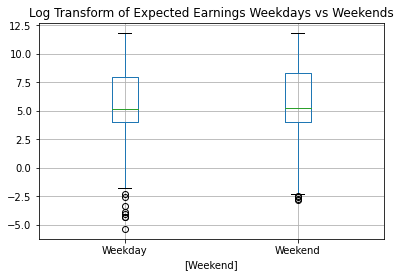

In [9]:
from matplotlib import *
from matplotlib import pyplot

# boxplot the logEE of weekdays vs weekends

dfWDExpEarnings['Weekend'] = 'Weekday'
dfWEExpEarnings['Weekend'] = 'Weekend'

concatEE = pd.concat([dfWDExpEarnings, dfWEExpEarnings])

bxplt = concatEE[['logEE', 'Weekend']].boxplot(by="Weekend")
bxplt.set_title("Log Transform of Expected Earnings Weekdays vs Weekends")
bxplt.get_figure().suptitle('')

pyplot.savefig("./plots/logEE.jpg", bbox_inches = 'tight')

In [10]:
sdfWeather = spark.read.csv('./raw_data/weather_data_JunToAug.csv', header=True)
 
# read in the weather data and take the readings from the Laguaradia Airport

laguardiaCode = "USW00014732"

doubles = ('LATITUDE', 'LONGITUDE', 'ELEVATION', 'AWND', 'PRCP', 
           'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN')
strings = ('STATION', 'NAME')
dates = ['DATE']
dtypes = {column: DoubleType() for column in doubles}
dtypes.update({column: StringType() for column in strings})
dtypes.update({column: DateType() for column in dates})

setSchema = StructType()
for column in sdfWeather.columns:
    setSchema.add(column,
                  dtypes[column],
                  True)
    
# Attach a schema to the weather data
sdfWeather = spark.read.csv('./raw_data/weather_data_JunToAug.csv', 
                            header=True, schema=setSchema)

# drop the irrelevant columns
sdfWeather = sdfWeather.drop("NAME") \
.drop('LATITUDE') \
.drop('LONGITUDE') \
.drop("ELEVATION") \
.filter(sdfWeather.STATION == laguardiaCode)

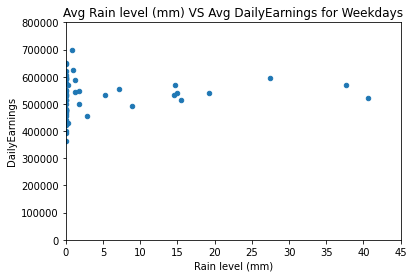

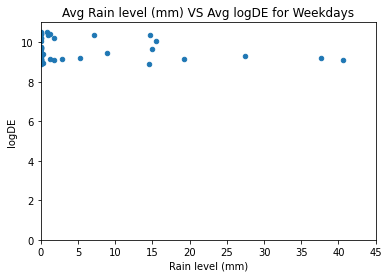

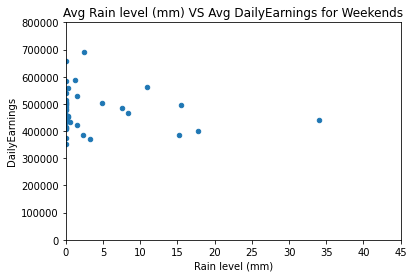

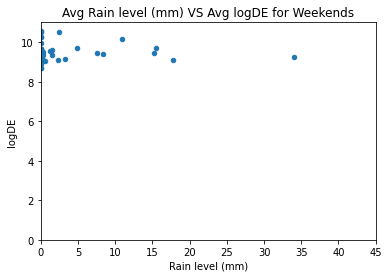

In [11]:
def borDailyEarnings(sdf):
    '''
    Calculate the DailyEarnings of each borough.
    DailyEarnings of a Borough is defined as the daily pickup count of a borough multiplied
    by the daily average total amount per trip
    '''
    # Join up up the table to the zone lookup table
    sdf2 = sdf.join(sdfZoneLookup, sdfZoneLookup.LocationID == sdf.PULocationID, "inner") \
    .drop("Zone") \
    .drop("service_zone") \
    .drop("LocationID")
    
    
    # calculate the daily pickup count per borough
    sdfBorDailyPU = sdf2.groupBy("PUDate", "Borough").count()
    
    sdfBorDailyPU = sdfBorDailyPU.join(sdfWeather, 
                                       sdfWeather.DATE == sdfBorDailyPU.PUDate, "inner") \
    .drop("DATE") \
    .drop("STATION")
    
    # calculate the average total amount per trip for each borough
    sdfBorAvgTot = sdf2.groupBy("PUDate", "Borough").avg("total_amount")
    sdfBorAvgTot = sdfBorAvgTot.withColumnRenamed("avg(total_amount)", "AvgTot")
    
    # calculate the DailyEarnings as defined in the docstring
    sdfBor = sdfBorAvgTot.join(sdfBorDailyPU, 
                               ((sdfBorAvgTot.PUDate == sdfBorDailyPU.PUDate) & 
                                (sdfBorAvgTot.Borough == sdfBorDailyPU.Borough)), 
                               "inner") \
    .drop(sdfBorAvgTot.PUDate) \
    .drop(sdfBorAvgTot.Borough)
    
    sdfBor = sdfBor.withColumn("DailyEarnings",
                               sdfBor["count"] * sdfBor["AvgTot"])\
    .drop("count")\
    .drop("AvgTot")
    
    # calculate the log transform of the DailyEarnings
    sdfBor = sdfBor.withColumn("logDE", F.log(sdfBor.DailyEarnings))
    
    return sdfBor


def PRCPvsX(sdf, X, Week):
    '''
    Function to plot the precipitation levels of a particular day
    against X
    '''
    sdfWDAvgDayX = sdf.groupBy("PUDate").avg(X)
    sdfWDAvgDayPrcp = sdf.groupBy("PUDate").avg("PRCP")
    dfWDAvgDay = sdfWDAvgDayX.join(sdfWDAvgDayPrcp, 
                                   sdfWDAvgDayPrcp.PUDate == sdfWDAvgDayX.PUDate, 
                                   "inner") \
    .drop(sdfWDAvgDayX.PUDate) \
    .toPandas()

    plot = dfWDAvgDay.plot.scatter(x = "avg(PRCP)", y = "avg(" + X + ")")
    plot.set(title = "Avg Rain level (mm) VS Avg " + X + " for " + Week,
             xlabel = "Rain level (mm)",
             ylabel = X)
    
    if (X == "DailyEarnings"):
        axes = pyplot.gca()
        axes.set_xlim([0,45])
        axes.set_ylim([0,800000])
    else:
        axes = pyplot.gca()
        axes.set_xlim([0,45])
        axes.set_ylim([0,11])
    
    
    figure = plot.get_figure()
    figure.savefig('./plots/'+Week+X+'.jpg', bbox_inches='tight')
    
    return plot

sdfBorWeekdays = borDailyEarnings(sdfWeekdays)
plot = PRCPvsX(sdfBorWeekdays, "DailyEarnings", "Weekdays")
plot = PRCPvsX(sdfBorWeekdays, "logDE", "Weekdays")


sdfBorWeekends = borDailyEarnings(sdfWeekends)
plot = PRCPvsX(sdfBorWeekends, "DailyEarnings", "Weekends")
plot = PRCPvsX(sdfBorWeekends, "logDE", "Weekends")

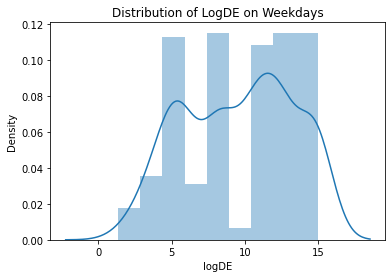

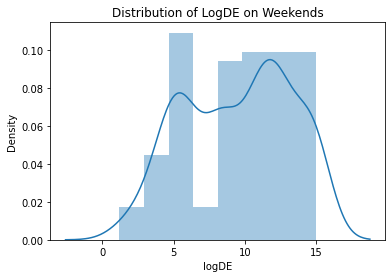

In [12]:
import seaborn as sns

# plot the histogram of logDE on weekdays and weekends to visually
# inspedt their distribution

def sturges(x):
    from numpy import log2
    return int(log2(x)) + 1

N = sdfBorWeekdays.count()
N2 = sdfBorWeekends.count()

dfWD = sdfBorWeekdays.toPandas()
dfWE = sdfBorWeekends.toPandas()

# bin the histograms according to the Sturges method
fig1 = sns.distplot(dfWD['logDE'], bins=sturges(N))
pyplot.title("Distribution of LogDE on Weekdays")
pyplot.show()

fig2 = sns.distplot(dfWE['logDE'], bins=sturges(N2))
pyplot.title("Distribution of LogDE on Weekends")
pyplot.show()

fig1.get_figure().savefig('./plots/logDEWeekdays.jpg')
fig2.get_figure().savefig('./plots/logDEWeekends.jpg')

In [13]:
# drop the unnecessary columns from the two data frames

sdfBorWeekdays = sdfBorWeekdays.drop("AWND") \
.drop("PRCP") \
.drop("SNOW") \
.drop("SNWD") \
.drop("TAVG") \
.drop("TMAX") \
.drop("TMIN")

sdfBorWeekends = sdfBorWeekends.drop("AWND") \
.drop("PRCP") \
.drop("SNOW") \
.drop("SNWD") \
.drop("TAVG") \
.drop("TMAX") \
.drop("TMIN")

In [21]:
# Join up the data again and convert to feather for analysis in R

dfWD = sdfBorWeekdays.toPandas()
dfWE = sdfBorWeekends.toPandas()
dfWD["Weekend"] = False
dfWE['Weekend'] = True

concatBoroughs = pd.concat([dfWD, dfWE]).reset_index().drop("index", axis = 1)
concatBoroughs.to_feather('./preprocessed_data/boroughsDailyEarnings.feather')

In [31]:
saveToParquet(sdfBorWeekdays, './preprocessed_data/WDBor.parquet')
saveToParquet(sdfBorWeekends, './preprocessed_data/WEBor.parquet')

21/08/10 20:51:59 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
21/08/10 20:51:59 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
21/08/10 20:52:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
21/08/10 20:52:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
21/08/10 20:52:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
21/08/10 20:52:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
